In [30]:
# Extensions
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [25]:
# Imports
import os
import torch
import pandas as pd
import numpy as np
import seqdatasets
import seqdata as sd
import xarray as xr
from eugene import preprocess as pp
from eugene.models.zoo import DeepBind, DeepSTARR
from eugene.models import SequenceModule
from eugene.models.base._metrics import calculate_metric
from eugene import plot as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger

# Configure sdata

In [6]:
sdata = seqdatasets.random1000()
pp.ohe_seqs_sdata(sdata)
pp.make_unique_ids_sdata(sdata)
pp.train_test_split_sdata(sdata)
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata

0it [00:00, ?it/s]

1000it [00:00, 1903.97it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 1000, _ohe: 4, length: 100, id: 1000)
Coordinates:
  * id          (id) <U7 'seq0000' 'seq0001' 'seq0002' ... 'seq0998' 'seq0999'
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/24)
    activity_0  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_1  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_2  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_3  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_4  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_5  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    ...          ...
    label_8     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    label_9     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq     (_sequence, _ohe, length) uint8 0 0 0 0 1 0 0 ... 1 0 0 0 0 0 0
    train_val   (id) bool False True False False ... False False False False
Attributes:
    max_jitter:  0

# Single task regression

In [7]:
# Set-up target
sdata["target"] = sdata["activity_0"].load()  #single task regression

In [8]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

In [14]:

arch = DeepBind(
    input_len=100,
    output_dim=1
)
arch

DeepBind(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 16, kernel_size=(16,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (max_pool): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(85,), stride=(85,), padding=(0,))
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [10]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = arch(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 100]), torch.Size([128]), torch.Size([128, 1]))

In [16]:
model = SequenceModule(
    arch=arch,
    task="regression",
    arch_name="DeepBind",
    model_name="random1000_DeepBind_regression",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
)
model.summary()

Model: DeepBind
Sequence length: 100
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.1 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)

In [17]:
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="random1000_DeepBind_regression",
    version="0.0.1"
)

In [18]:
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())

In [22]:
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

tensor(-1.1880)

In [23]:
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.1 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The numbe

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


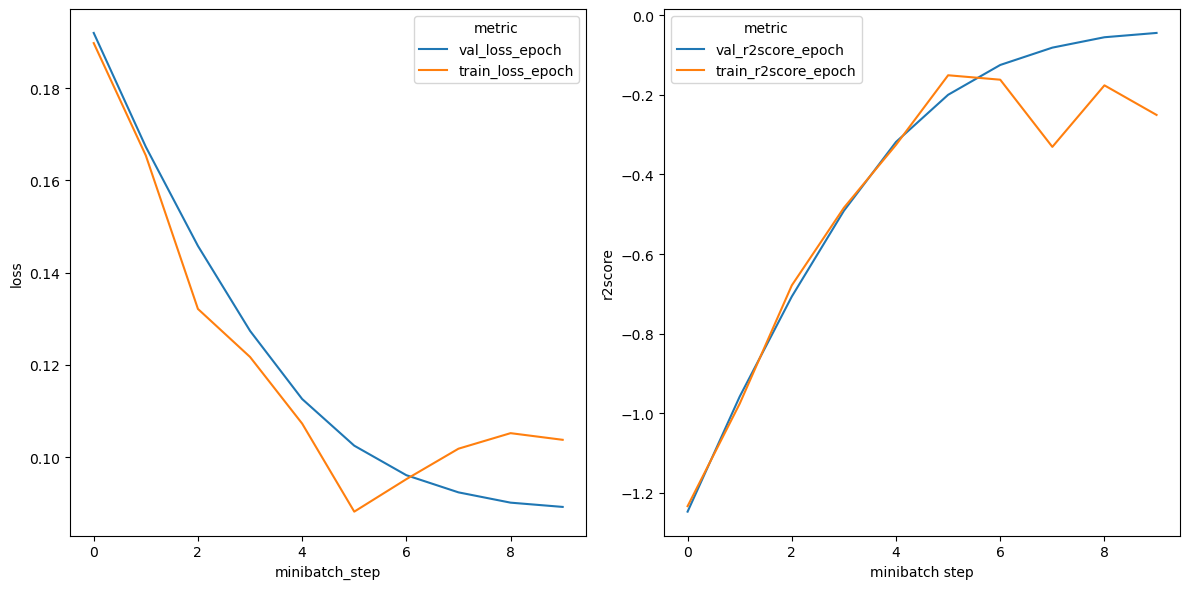

In [27]:
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# Multitask regression

In [99]:
# Set-up target
target_keys = ["activity_1", "activity_2", "activity_3"]
sdata["target"] = xr.concat([sdata[target_key] for target_key in target_keys], dim="_targets").transpose("_sequence", "_targets").load() # multitask task regression

In [106]:
targs = sdata["target"].values

In [107]:
targs

array([[0.15354687, 0.85626331, 0.73107307],
       [0.49185131, 0.65403882, 0.84788125],
       [0.18075472, 0.54686202, 0.25594359],
       ...,
       [0.03767318, 0.51178497, 0.41919342],
       [0.52372604, 0.46613537, 0.03764074],
       [0.7384776 , 0.4260379 , 0.53956907]])

In [103]:
import pyBigWig

In [104]:
signal = "/cellar/users/aklie/data/ml4gland/use_cases/avsec21/ENCSR000EGM/data/plus.bw"

In [105]:
with pyBigWig.open(signal, "r") as bw:
    print(bw.chroms())

{'chr1': 248956422, 'chr10': 133797422, 'chr11': 135086622, 'chr11_KI270721v1_random': 100316, 'chr12': 133275309, 'chr13': 114364328, 'chr14': 107043718, 'chr14_GL000009v2_random': 201709, 'chr14_GL000194v1_random': 191469, 'chr14_GL000225v1_random': 211173, 'chr14_KI270722v1_random': 194050, 'chr14_KI270723v1_random': 38115, 'chr14_KI270724v1_random': 39555, 'chr14_KI270725v1_random': 172810, 'chr14_KI270726v1_random': 43739, 'chr15': 101991189, 'chr15_KI270727v1_random': 448248, 'chr16': 90338345, 'chr16_KI270728v1_random': 1872759, 'chr17': 83257441, 'chr17_GL000205v2_random': 185591, 'chr17_KI270729v1_random': 280839, 'chr17_KI270730v1_random': 112551, 'chr18': 80373285, 'chr19': 58617616, 'chr1_KI270706v1_random': 175055, 'chr1_KI270707v1_random': 32032, 'chr1_KI270708v1_random': 127682, 'chr1_KI270709v1_random': 66860, 'chr1_KI270710v1_random': 40176, 'chr1_KI270711v1_random': 42210, 'chr1_KI270712v1_random': 176043, 'chr1_KI270713v1_random': 40745, 'chr1_KI270714v1_random': 417

In [29]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

In [41]:
arch = DeepBind(
    input_len=100,
    output_dim=3
)
arch

DeepBind(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 16, kernel_size=(16,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (max_pool): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(85,), stride=(85,), padding=(0,))
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=32, out_features=3, bias=True)
    )
  )
)

In [42]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = arch(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 100]), torch.Size([128, 3]), torch.Size([128, 3]))

In [53]:
model = SequenceModule(
    arch=arch,
    task="regression",
    arch_name="DeepBind",
    model_name="random1000_DeepBind_regression",
    scheduler="reduce_lr_on_plateau",
    scheduler_kwargs={"patience": 2},
    metric="r2score",
    metric_kwargs={"num_classes": 3}
)
model.summary()

Model: DeepBind
Sequence length: 100
Output dimension: 3
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {'num_classes': 3}
Seed: None
Parameters summary:


  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.2 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)

In [54]:
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

tensor(-2.1507)

In [55]:
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="random1000_DeepBind_multitask_regression",
    version="0.0.1"
)

In [56]:
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())

In [57]:
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.2 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The numbe

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


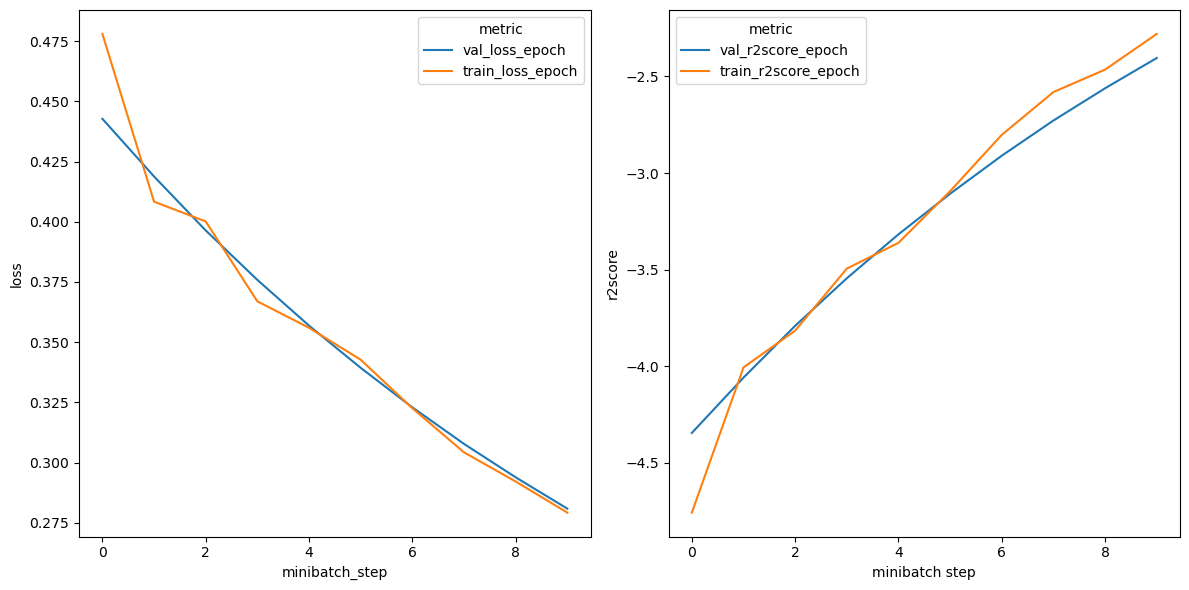

In [49]:
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

In [ ]:
model = SequenceModule(
    arch=arch,
    task="regression",
    arch_name="DeepSTARR",
    model_name="random1000_deepstarr",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
    #metric_kwargs={"num_classes": 3, "task": "multiclass"}
)

# Single task classification

In [59]:
# Set-up target
sdata["target"] = sdata["label_0"].load()  #single task regression

In [60]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

In [61]:
arch = DeepBind(
    input_len=100,
    output_dim=1
)
arch

DeepBind(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 16, kernel_size=(16,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (max_pool): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(85,), stride=(85,), padding=(0,))
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [62]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = arch(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 100]), torch.Size([128]), torch.Size([128, 1]))

In [65]:
model = SequenceModule(
    arch=arch,
    task="binary_classification",
    loss_fxn="bce",
    arch_name="DeepBind",
    model_name="random1000_DeepBind_regression",
    scheduler="reduce_lr_on_plateau",
    metric="auroc",
)
model.summary()

Model: DeepBind
Sequence length: 100
Output dimension: 1
Task: binary_classification
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: auroc
	Metric parameters: {'task': 'binary'}
Seed: None
Parameters summary:


  | Name         | Type        | Params
---------------------------------------------
0 | arch         | DeepBind    | 2.1 K 
1 | train_metric | BinaryAUROC | 0     
2 | val_metric   | BinaryAUROC | 0     
3 | test_metric  | BinaryAUROC | 0     
---------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)

In [66]:
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="random1000_DeepBind_binary_classification",
    version="0.0.1"
)

In [67]:
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())

In [72]:
model.train_metric

BinaryAUROC()

In [73]:
def calculate_metric(
    metric,
    metric_name,
    outs,
    y
):
    """Calculate a metric from a metric name and the model outputs and targets.

    Args:
        metric (torchmetrics.Metric): The metric to calculate.
        metric_name (str): The name of the metric.
        y (torch.Tensor): The targets.
        outs (torch.Tensor): The model outputs.

    Returns:
        float: The calculated metric.
    """
    if metric_name in ["accuracy", "auroc", "f1score", "precision", "recall"]:
        if len(y.shape) > 1:
            y = torch.argmax(y.squeeze(), dim=1)
    else:
        outs = outs.squeeze()
    metric(outs, y)

In [74]:
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

tensor(0.4640)

In [ ]:
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.1 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The numbe

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


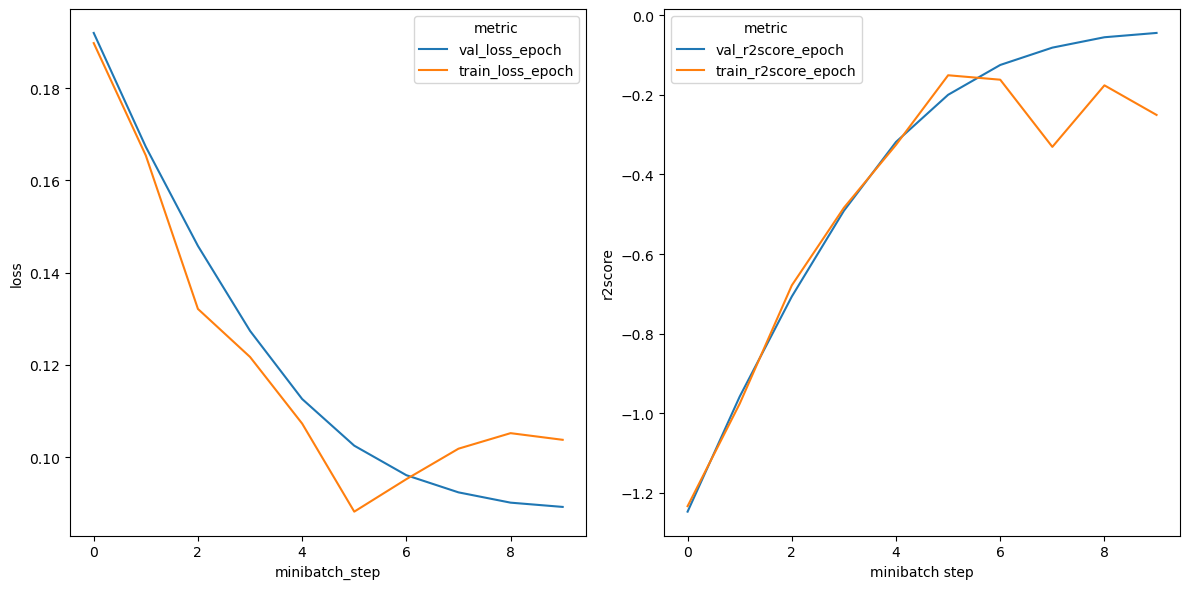

In [ ]:
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# Multitask classification

In [75]:
sdata["target"] = xr.concat([sdata["label_0"], sdata["label_1"], sdata["label_2"]], dim="_targets").transpose("_sequence", "_targets").load()

In [76]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

In [77]:
arch = DeepBind(
    input_len=100,
    output_dim=3
)
arch

DeepBind(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 16, kernel_size=(16,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (max_pool): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(85,), stride=(85,), padding=(0,))
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=32, out_features=3, bias=True)
    )
  )
)

In [78]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = arch(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 100]), torch.Size([128, 3]), torch.Size([128, 3]))

In [80]:
model = SequenceModule(
    arch=arch,
    task="multiclass_classification",
    arch_name="DeepBind",
    loss_fxn="cross_entropy"
    model_name="random1000_DeepBind_multiclass_classification",
    scheduler="reduce_lr_on_plateau",
    metric="auroc",
    metric_kwargs={"num_classes": 3, "task": "multiclass"}
)
model.summary()

Model: DeepBind
Sequence length: 100
Output dimension: 3
Task: multiclass_classification
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: auroc
	Metric parameters: {'num_classes': 3, 'task': 'multiclass'}
Seed: None
Parameters summary:


  | Name         | Type            | Params
-------------------------------------------------
0 | arch         | DeepBind        | 2.2 K 
1 | train_metric | MulticlassAUROC | 0     
2 | val_metric   | MulticlassAUROC | 0     
3 | test_metric  | MulticlassAUROC | 0     
-------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)

In [81]:
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="random1000_DeepBind_multiclass_classification",
    version="0.0.1"
)

In [82]:
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())

In [83]:
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

tensor(0.4762)

In [84]:
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [85]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params
-------------------------------------------------
0 | arch         | DeepBind        | 2.2 K 
1 | train_metric | MulticlassAUROC | 0     
2 | val_metric   | MulticlassAUROC | 0     
3 | test_metric  | MulticlassAUROC | 0     
-------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The numbe

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


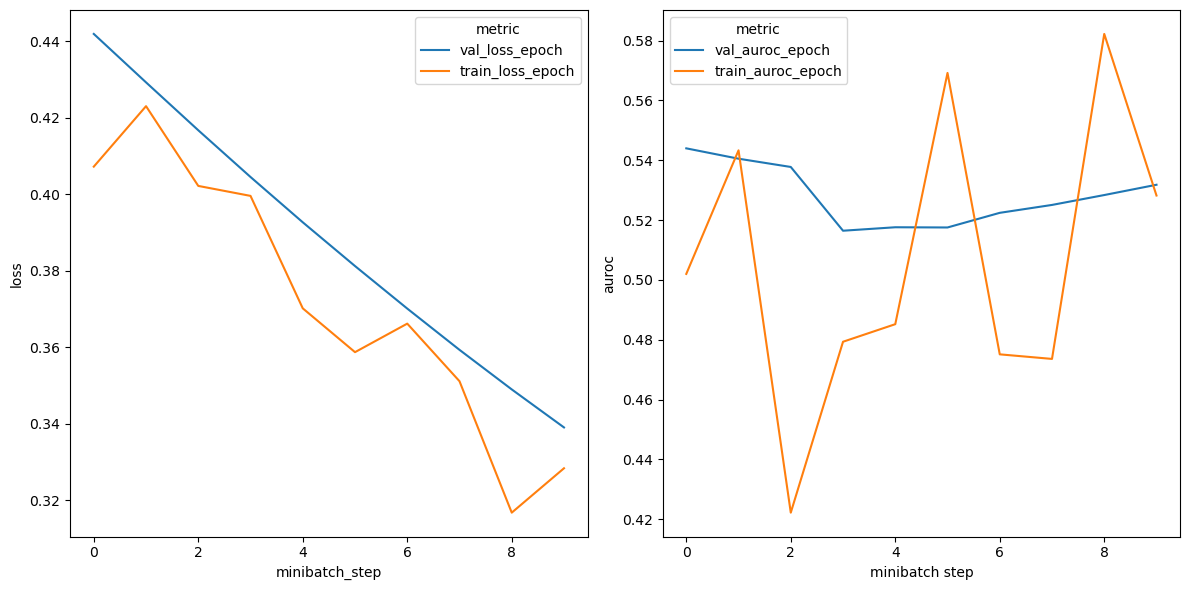

In [87]:
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="auroc")

# Multilabel classification

# DONE

---

# Scratch